## Priprava okolja in nalaganje knjižnic

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil # Za brisanje map, če jih želimo ponastaviti

## Ekstrakcija frejmov iz videa

In [14]:
# Definiramo pot do video datoteke in izhodne mape
video_path = 'data/video/selfiVideo.mp4' # Prilagodi to pot do tvojega videa
output_frames_folder = 'data/frames/oseba_1/'

# Začnimo s čisto mapo, da se ne nabirajo stari frejmi
if os.path.exists(output_frames_folder):
    shutil.rmtree(output_frames_folder) # Pobrišemo mapo, če že obstaja
os.makedirs(output_frames_folder, exist_ok=True) # Sedaj ustvarimo novo, prazno mapo

# Odpremo video
vidcap = cv2.VideoCapture(video_path)
success, image = vidcap.read()
count = 0
frame_save_interval = 5 # Vsak 5. frejm

print(f"Začenjam z ekstrakcijo frejmov iz videa: {video_path}")

while success:
    # Shranimo samo vsak 'frame_save_interval' frejm, da ne preobremenimo sistema
    if count % frame_save_interval == 0:
        frame_filename = os.path.join(output_frames_folder, f"frame_{count:04d}.jpg")
        cv2.imwrite(frame_filename, image)
        # print(f"Shranjujem frejm: {frame_filename}") # Lahko vključiš, če želiš videti vsak frejm
    success, image = vidcap.read()
    count += 1

print(f"Končana ekstrakcija. Skupaj obdelano {count} frejmov. Shranjenih {len(os.listdir(output_frames_folder))} slik v {output_frames_folder}.")

Začenjam z ekstrakcijo frejmov iz videa: data/video/selfiVideo.mp4
Končana ekstrakcija. Skupaj obdelano 377 frejmov. Shranjenih 76 slik v data/frames/oseba_1/.


## Odstranjevanje šuma iz vseh frejmov in prikaz primera

Izvedel odstranjevanje šuma in poskrbel za pravilen barvni model. Čeprav navodila omenjajo "linearizacijo sivin", sem se odločil, da za nadaljnje delo z modelom prepoznavanja obraza ohranim barvne (RGB) slike, saj te vsebujejo več informacij in običajno zagotavljajo boljše rezultate pri takšni nalogi

Začenjam z odstranjevanjem šuma iz 76 slik...
Končano odstranjevanje šuma. Očiščene slike shranjene v: data/intermediate/oseba_1_cleaned/


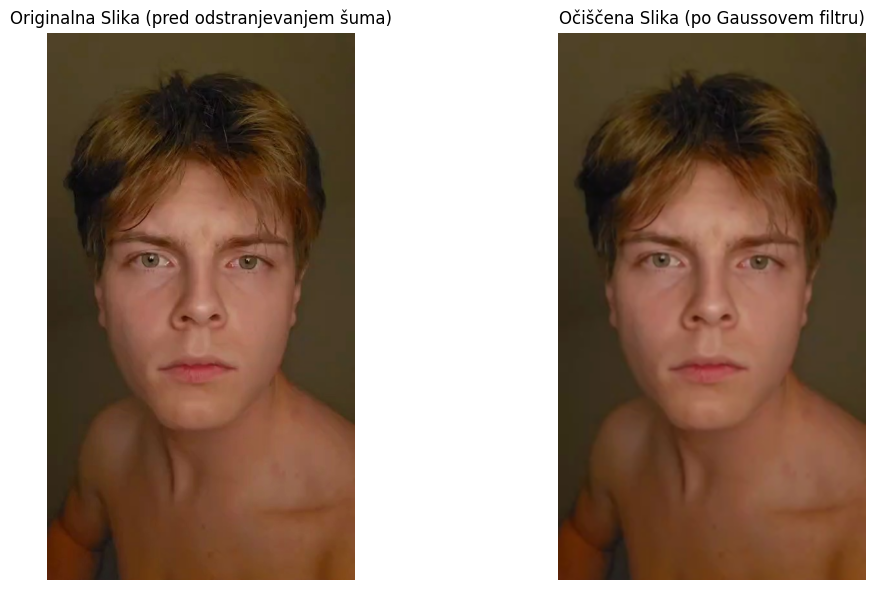

In [21]:
# Definiramo mapo z originalnimi frejmi in mapo za očiščene frejme
input_frames_folder = output_frames_folder # To so frejmi, ki smo jih ravnokar ekstrahirali
output_cleaned_folder = 'data/intermediate/oseba_1_cleaned/'

# Pripravimo mapo za očiščene frejme
if os.path.exists(output_cleaned_folder):
    shutil.rmtree(output_cleaned_folder)
os.makedirs(output_cleaned_folder, exist_ok=True)

all_frames = sorted(os.listdir(input_frames_folder))
example_original_image_rgb = None
example_cleaned_image_rgb = None
example_processed = False # Zastavica, da prikažemo samo en primer

print(f"Začenjam z odstranjevanjem šuma iz {len(all_frames)} slik...")

for i, frame_name in enumerate(all_frames):
    frame_path = os.path.join(input_frames_folder, frame_name)
    image_bgr = cv2.imread(frame_path)

    if image_bgr is None:
        print(f"Opozorilo: Slike ni mogoče naložiti: {frame_path}. Preskakujem.")
        continue

    # OpenCV bere BGR, MediaPipe in Matplotlib pa pričakujeta RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # --- Uporabimo Gaussov filter za odstranjevanje šuma ---
    # Jedro (kernel size) 5x5 je dobra začetna točka. Boljše vrednosti lahko preizkusim kasneje.
    # Večje jedro pomeni boljše zglajevanje, a tudi večjo izgubo detajlov.
    cleaned_image_rgb = cv2.GaussianBlur(image_rgb, (5, 5), 0)

    # Shranimo očiščeno sliko v novo mapo
    cleaned_frame_filename = os.path.join(output_cleaned_folder, f"cleaned_{frame_name}")
    cv2.imwrite(cleaned_frame_filename, cv2.cvtColor(cleaned_image_rgb, cv2.COLOR_RGB2BGR))

    # Shrani en primer za prikaz
    if not example_processed:
        example_original_image_rgb = image_rgb
        example_cleaned_image_rgb = cleaned_image_rgb
        example_processed = True # Po prvem primeru nastavimo na True, da ne shranjujemo več

print(f"Končano odstranjevanje šuma. Očiščene slike shranjene v: {output_cleaned_folder}")

# --- Prikaz enega primera očiščene slike ---
if example_original_image_rgb is not None:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(example_original_image_rgb)
    plt.title('Originalna Slika (pred odstranjevanjem šuma)')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(example_cleaned_image_rgb)
    plt.title('Očiščena Slika (po Gaussovem filtru)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Ni bilo slik za obdelavo ali prikaz primera.")